In [1]:
import torch
import logging
import pandas as pd


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import os
import torch
from PIL import Image
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
%matplotlib inline
import torch.nn.functional as F
import torch.optim as optim
import random
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score
)

import math, time, copy
from torch.utils.data import Subset


from typing import Optional
from torch.amp import autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau

from image_dataset import ImageDataset

In [2]:
SEED = 42
DATA_DIR = "./data"
LABEL_FILE_PATH =  f"{DATA_DIR}/train_labels.csv"
TRAIN_DIR = f"{DATA_DIR}/train"
TEST_DIR = f"{DATA_DIR}/test"
BATCH_SIZE = 4
NUM_WORKERS = 4
SHAPE = (96, 96, 3)

best_resnet_path = "./checkpoints/best_resnet50_mps.pth"
best_cnn_path = "./checkpoints/best_simplecnn_mps.pth"

In [3]:
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
g = torch.Generator().manual_seed(SEED)

In [4]:

device_name = "cpu"
if torch.cuda.is_available():
    device_name = "cuda"
if torch.backends.mps.is_available():
    device_name = "mps"

device = torch.device(device_name)

print(f"Using device: {device}")

Using device: mps


In [5]:
labels_df = pd.read_csv(LABEL_FILE_PATH)
labels_df.set_index("id", inplace=True)

In [6]:
data_transformer = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
ds = ImageDataset(data_dir=DATA_DIR, transform=data_transformer, label_df=labels_df, data_type="train")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


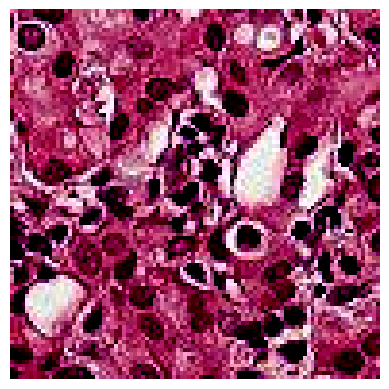

label: 1


In [7]:
# get a sample from the dataset
sample_image, sample_label = ds[0]
# show image
plt.imshow(sample_image.permute(1, 2, 0))
plt.axis('off')
plt.show()
print(f"label: {sample_label}")

In [8]:
trainset, valset = random_split(
    ds, [int(0.8 * len(ds)), len(ds) - int(0.8 * len(ds))], generator=g
)

In [9]:

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,
                                          num_workers=NUM_WORKERS, persistent_workers=True)
testloader  = torch.utils.data.DataLoader(valset,   batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, persistent_workers=True)

In [10]:
def evaluate(model, loader, criterion, device):
    model.eval()
    losses, probs_all, y_all = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).float().unsqueeze(1)     # (B,1)
            logits = model(x)
            loss = criterion(logits, y)
            losses.append(loss.item())
            probs = torch.sigmoid(logits)             # (B,1)
            probs_all.append(probs.cpu())
            y_all.append(y.cpu())
    probs_all = torch.cat(probs_all).squeeze(1).numpy()
    y_all = torch.cat(y_all).squeeze(1).numpy()
    auc = roc_auc_score(y_all, probs_all)
    acc = accuracy_score(y_all, (probs_all >= 0.5).astype(int))



    return sum(losses)/len(losses), acc, auc

In [11]:
class SimpleCNN(nn.Module):
    """
    A simple Convolutional Neural Network for binary classification of histopathological images.
    The architecture inspired by common CNN structures includes three convolutional layers followed by max pooling,
    a fully connected layer, dropout for regularization, and a final output layer.

    The input images are expected to have three channels (RGB) and a shape of (96, 96, 3) as it's the default shape in the dataset.
    The output is a single logit value for binary classification.
    The model uses ReLU activation functions after each convolutional layer and before the final output layer.
    Dropout is applied after the first fully connected layer to prevent overfitting.
    The model is designed to be trained with a binary cross-entropy loss function, specifically using
    `nn.BCEWithLogitsLoss`, which combines a sigmoid layer and the binary cross-entropy loss in a single class.
    This is more numerically stable than using a plain Sigmoid followed by a BCELoss.

    Args:
        dropout_p (float): Probability of an element to be zeroed in the dropout layer.
                           Default is 0.5, which means 50% of the elements will be set to zero during training.
    Returns:
        A PyTorch model that can be trained on histopathological images for binary classification.
    The model's forward method takes an input tensor of shape (B, 3, 96, 96) where B is the batch size,
    and returns an output tensor of shape (B, 1) containing the logit values for each image in the batch.
    """
    def __init__(self, dropout_p: float = 0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3) # input channels 3 (RGB), output channels 32 (feature maps), output shape is (B, 32, 94, 94) ==> (96-3)/1 + 1 = 94
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # halve spatial dims ==> (94-2)/2 + 1 = 47, output shape is (B, 32, 47, 47)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) # in_channels=32 from previous layer, out_channels=64 (feature maps), output shape is (B, 64, 45, 45) ==> (47-3)/1 + 1 = 45
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # halve spatial dims again ==> (45-2)/2 + 1 = 22, output shape is (B, 64, 22, 22)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3) # in_channels=64 from previous layer, out_channels=128 (feature maps), output shape is (B, 128, 20, 20) ==> (22-3)/1 + 1 = 20
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # halve spatial dims again ==> (20 - 2)/2 + 1 = 10, output shape is (B, 128, 10, 10)

        # the shape after the last pooling layer is (B, 128, 10, 10)
        self.fc1 = nn.Linear(in_features=128 * 10 * 10, out_features=128)
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(in_features=128, out_features=1)  # binary logit output

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = torch.flatten(x, 1)      # flatten all dims except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)              # no sigmoid here (use BCEWithLogitsLoss)
        return x


In [12]:

def compute_pos_weight(dataset_or_subset, device):
    if isinstance(dataset_or_subset, Subset):
        base_ds = dataset_or_subset.dataset    # the underlying ImageDataset
        idxs = dataset_or_subset.indices
        labels = [base_ds.items[i][1] for i in idxs]
    else:
        labels = [lbl for _, lbl in dataset_or_subset.items]

    labels_t = torch.as_tensor(labels, dtype=torch.long)
    counts = torch.bincount(labels_t, minlength=2)  # [neg, pos]
    neg, pos = counts[0].item(), counts[1].item()
    pos = max(pos, 1)
    return torch.tensor([neg / pos], device=device, dtype=torch.float32)

simple_cnn_model = SimpleCNN().to(device)
pos_weight = compute_pos_weight(trainset, device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # pos_weight to handle class imbalance
optimizer = torch.optim.Adam(simple_cnn_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

In [13]:
def train_simplecnn_mps(
    model: nn.Module,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    *,
    epochs: int = 10,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None,
    early_stopping_patience: int = 3,
    grad_clip: Optional[float] = None,
    best_path: str = best_cnn_path,  # Path to save the best model checkpoint
):
    """
    MPS-optimized training for SimpleCNN.
    - Uses autocast("mps") when device.type == "mps".
    - No GradScaler (MPS doesn't use it).
    - Tracks best checkpoint by validation AUC.
    Returns: (best_model, history)
    """
    use_amp = device.type == "mps"

    best_auc = -math.inf
    best_state = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0
    history = []

    for epoch in range(1, epochs + 1):
        t0 = time.perf_counter()
        model.train()
        running_loss = 0.0

        for imgs, labels in train_loader:
            imgs = imgs.to(device, non_blocking=False)
            labels = labels.to(device, non_blocking=False).float().unsqueeze(1)

            optimizer.zero_grad(set_to_none=True)

            if use_amp:
                with autocast("mps"):
                    logits = model(imgs)
                    loss = criterion(logits, labels)
            else:
                logits = model(imgs)
                loss = criterion(logits, labels)

            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            running_loss += loss.item()

        # --- Validation ---
        val_loss, val_acc, val_auc = evaluate(model, val_loader, criterion, device)

        # --- Scheduler ---
        if scheduler is not None:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(val_auc)
            else:
                scheduler.step()

        # --- Keep best by AUC ---
        if val_auc > best_auc:
            best_auc = val_auc
            best_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            torch.save(
                {
                    "model_state": best_state,
                    "optimizer_state": optimizer.state_dict(),
                    "scheduler_state": (
                        scheduler.state_dict() if scheduler is not None else None
                    ),
                    "auc": best_auc,
                    "epoch": epoch,
                },
                best_path,
            )
            print(f"[SimpleCNN-MPS] Saved best checkpoint to {best_path}")
        else:
            epochs_no_improve += 1

        dt = time.perf_counter() - t0
        train_loss = running_loss / max(1, len(train_loader))

        # LR log (handles single/multi param groups)
        lrs = (
            [pg.get("lr", float("nan")) for pg in optimizer.param_groups]
            if hasattr(optimizer, "param_groups")
            else []
        )
        lr_str = ",".join(f"{lr:.2e}" for lr in lrs) if lrs else "n/a"

        print(
            f"[SimpleCNN-MPS] epoch {epoch:02d} | "
            f"train_loss {train_loss:.4f} | val_loss {val_loss:.4f} | "
            f"val_acc {val_acc:.4f} | val_auc {val_auc:.4f} | "
            f"lr {lr_str} | {dt:.1f}s"
        )

        history.append(
            {
                "epoch": epoch,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_auc": val_auc,
                "lrs": lrs,
                "time_s": dt,
            }
        )

        # --- Early stopping ---
        if (
            early_stopping_patience is not None
            and epochs_no_improve >= early_stopping_patience
        ):
            print(
                f"[SimpleCNN-MPS] Early stopping after {epoch} epochs (no AUC improvement)."
            )
            break

    # Load best checkpoint
    model.load_state_dict(best_state)
    return model, history

In [14]:
simple_cnn_model, hist = train_simplecnn_mps(
    simple_cnn_model,
    trainloader,
    testloader,
    criterion,
    optimizer,
    device,
    epochs=15,
    scheduler=scheduler,
    early_stopping_patience=4,
    grad_clip=1.0, 
)

[SimpleCNN-MPS] Saved best checkpoint to ./checkpoints/best_simplecnn_mps.pth
[SimpleCNN-MPS] epoch 01 | train_loss 0.6305 | val_loss 0.6657 | val_acc 0.8630 | val_auc 0.9322 | lr 1.00e-03 | 253.4s
[SimpleCNN-MPS] Saved best checkpoint to ./checkpoints/best_simplecnn_mps.pth
[SimpleCNN-MPS] epoch 02 | train_loss 0.5575 | val_loss 0.4964 | val_acc 0.8704 | val_auc 0.9414 | lr 1.00e-03 | 246.6s
[SimpleCNN-MPS] epoch 03 | train_loss 0.5412 | val_loss 0.6822 | val_acc 0.8619 | val_auc 0.9338 | lr 1.00e-03 | 247.5s
[SimpleCNN-MPS] Saved best checkpoint to ./checkpoints/best_simplecnn_mps.pth
[SimpleCNN-MPS] epoch 04 | train_loss 0.5344 | val_loss 0.4392 | val_acc 0.8871 | val_auc 0.9511 | lr 1.00e-03 | 248.3s
[SimpleCNN-MPS] epoch 05 | train_loss 0.5285 | val_loss 0.5003 | val_acc 0.8787 | val_auc 0.9483 | lr 1.00e-03 | 240.6s
[SimpleCNN-MPS] epoch 06 | train_loss 0.5205 | val_loss 0.7154 | val_acc 0.8697 | val_auc 0.9267 | lr 1.00e-03 | 240.3s
[SimpleCNN-MPS] epoch 07 | train_loss 0.5212 |

In [15]:
val_loss, val_acc, val_auc = evaluate(simple_cnn_model, testloader, criterion, device)
print(f"[SimpleCNN-MPS BEST] val_loss: {val_loss:.4f}  val_acc: {val_acc:.4f}  val_auc: {val_auc:.4f}")

[SimpleCNN-MPS BEST] val_loss: 0.4659  val_acc: 0.9024  val_auc: 0.9606


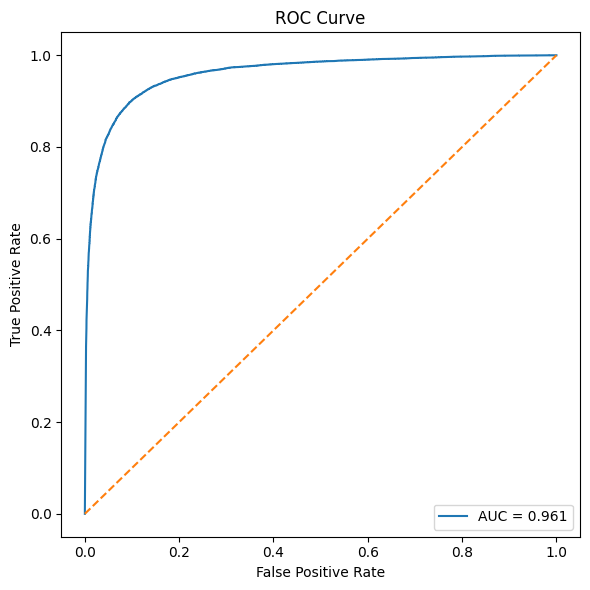

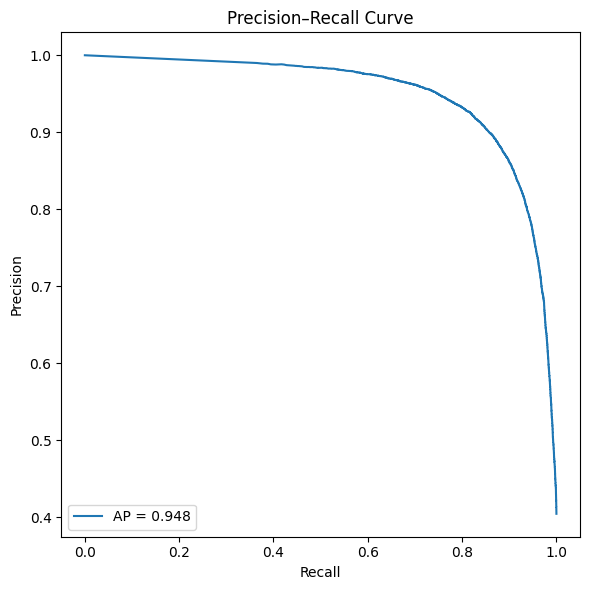

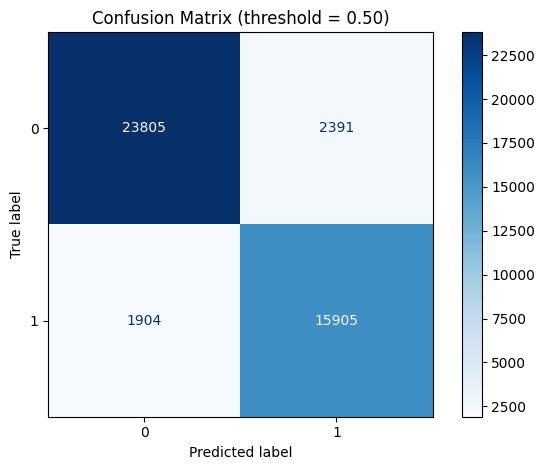

In [16]:
@torch.no_grad()
def collect_probs_and_labels(model, loader, device):
    model.eval()
    probs_all, y_all = [], []
    for x, y in loader:
        x = x.to(device)
        y = y.to(device).float().unsqueeze(1)
        logits = model(x)
        probs = torch.sigmoid(logits)
        probs_all.append(probs.cpu())
        y_all.append(y.cpu())
    probs_all = torch.cat(probs_all).squeeze(1).numpy()
    y_all = torch.cat(y_all).squeeze(1).numpy()
    return probs_all, y_all

probs_all, y_all = collect_probs_and_labels(simple_cnn_model, testloader, device)

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_all, probs_all)
roc_auc = roc_auc_score(y_all, probs_all)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# --- Precision–Recall Curve ---
prec, rec, _ = precision_recall_curve(y_all, probs_all)
ap = average_precision_score(y_all, probs_all)

plt.figure(figsize=(6, 6))
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# --- Confusion Matrix ---
# You can tweak the threshold. 0.5 is common; for imbalanced data, you might pick the threshold
# that maximizes F1 on the validation set.
threshold = 0.5
y_pred = (probs_all >= threshold).astype(int)

cm = confusion_matrix(y_all, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(values_format="d", cmap="Blues")
plt.title(f"Confusion Matrix (threshold = {threshold:.2f})")
plt.tight_layout()
plt.show()


## Transfer Learning with ResNet50


In [17]:
# ImageNet normalization
IMAGENET_MEAN = ResNet50_Weights.IMAGENET1K_V2.transforms().mean
IMAGENET_STD  = ResNet50_Weights.IMAGENET1K_V2.transforms().std

resnet_train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

resnet_val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [18]:
# Base datasets with ResNet transforms
ds_train_resnet = ImageDataset(DATA_DIR, transform=resnet_train_tf, label_df=labels_df, data_type="train")
ds_val_resnet   = ImageDataset(DATA_DIR, transform=resnet_val_tf,   label_df=labels_df, data_type="train")

# Reuse the exact same split indices
trainset_resnet = torch.utils.data.Subset(ds_train_resnet, trainset.indices)
valset_resnet   = torch.utils.data.Subset(ds_val_resnet,   valset.indices)

# (Optional but recommended on CUDA)
pin_mem = (device.type == "cuda")

trainloader_resnet = torch.utils.data.DataLoader(
    trainset_resnet, batch_size=16, shuffle=True, num_workers=2, pin_memory=pin_mem
)
valloader_resnet = torch.utils.data.DataLoader(
    valset_resnet, batch_size=32, shuffle=False, num_workers=2, pin_memory=pin_mem
)

In [19]:
pos_weight = compute_pos_weight(trainset_resnet, device)
criterion_resnet = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [20]:
def build_resnet50_model(fine_tune_last_block: bool = True):
    weights = ResNet50_Weights.IMAGENET1K_V2
    model = resnet50(weights=weights)

    # Replace classifier head for binary logit output
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 1)

    # Freeze everything
    for p in model.parameters():
        p.requires_grad = False

    if fine_tune_last_block:
        for p in model.layer4.parameters():
            p.requires_grad = True
        for p in model.fc.parameters():
            p.requires_grad = True
    else:
        # Head-only: train only the last fc layer
        for p in model.fc.parameters():
            p.requires_grad = True

    return model.to(device)


resnet_model = build_resnet50_model(fine_tune_last_block=True)

# Parameter groups: lower LR for backbone, higher for head
backbone_params = [
    p
    for n, p in resnet_model.named_parameters()
    if p.requires_grad and not n.startswith("fc.")
]
head_params = [
    p
    for n, p in resnet_model.named_parameters()
    if n.startswith("fc.") and p.requires_grad
]

optimizer_resnet = optim.AdamW(
    [
        {"params": backbone_params, "lr": 3e-5},  # gentle fine-tuning
        {"params": head_params, "lr": 1e-3},  # faster on the new head
    ],
    weight_decay=1e-4,
)

scheduler_resnet = ReduceLROnPlateau(
    optimizer_resnet, mode="max", factor=0.5, patience=2
)

4.9%

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/mark/.xdg_cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100.0%


In [21]:
def train_resnet_mps(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=10):
    use_amp = (device.type == "mps")
    best_auc, best_state = -1.0, copy.deepcopy(model.state_dict())

    for epoch in range(1, epochs+1):
        t0 = time.perf_counter()
        model.train()
        running = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device); labels = labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad(set_to_none=True)
            if use_amp:
                with autocast("mps"):
                    logits = model(imgs); loss = criterion(logits, labels)
            else:
                logits = model(imgs); loss = criterion(logits, labels)
            loss.backward(); optimizer.step()
            running += loss.item()

        val_loss, val_acc, val_auc = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_auc)

        if val_auc > best_auc:
            best_auc = val_auc
            best_state = copy.deepcopy(model.state_dict())
            torch.save({"model": best_state, "auc": best_auc, "epoch": epoch}, best_resnet_path)
            print(f"[ResNet50] Saved best checkpoint to {best_resnet_path}")

        dt = time.perf_counter() - t0
        print(f"[ResNet50] epoch {epoch:02d} | train_loss {running/len(train_loader):.4f} "
              f"| val_loss {val_loss:.4f} | val_acc {val_acc:.4f} | val_auc {val_auc:.4f} | {dt:.1f}s")

    model.load_state_dict(best_state)
    return model        

train_resnet_mps(
    resnet_model, trainloader_resnet, valloader_resnet,
    criterion_resnet, optimizer_resnet, scheduler_resnet, device,
    epochs=10
)

[ResNet50] Saved best checkpoint to ./checkpoints/best_resnet50_mps.pth
[ResNet50] epoch 01 | train_loss 0.3080 | val_loss 0.2429 | val_acc 0.9275 | val_auc 0.9744 | 1171.9s
[ResNet50] Saved best checkpoint to ./checkpoints/best_resnet50_mps.pth
[ResNet50] epoch 02 | train_loss 0.2213 | val_loss 0.2093 | val_acc 0.9356 | val_auc 0.9808 | 1130.0s
[ResNet50] epoch 03 | train_loss 0.1920 | val_loss 0.2271 | val_acc 0.9371 | val_auc 0.9804 | 1146.2s
[ResNet50] Saved best checkpoint to ./checkpoints/best_resnet50_mps.pth
[ResNet50] epoch 04 | train_loss 0.1727 | val_loss 0.2074 | val_acc 0.9474 | val_auc 0.9832 | 1146.2s
[ResNet50] Saved best checkpoint to ./checkpoints/best_resnet50_mps.pth
[ResNet50] epoch 05 | train_loss 0.1570 | val_loss 0.2062 | val_acc 0.9446 | val_auc 0.9848 | 1141.9s
[ResNet50] Saved best checkpoint to ./checkpoints/best_resnet50_mps.pth
[ResNet50] epoch 06 | train_loss 0.1453 | val_loss 0.1864 | val_acc 0.9510 | val_auc 0.9865 | 1142.0s
[ResNet50] epoch 07 | train_

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

[ResNet50] val_loss: 0.1855  val_acc: 0.9572  val_auc: 0.9892


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

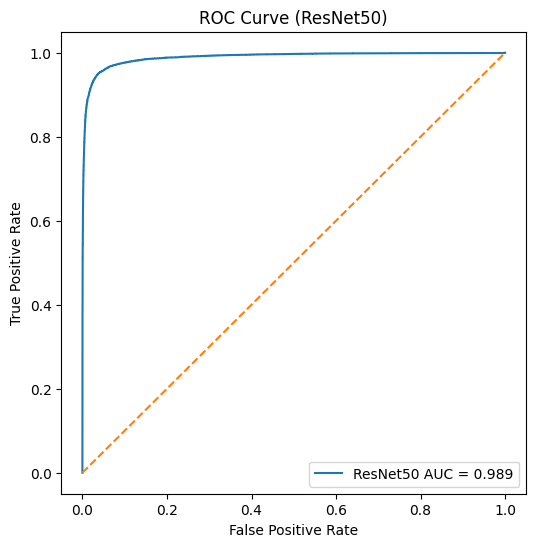

In [22]:
# Final metrics on validation
val_loss_rn, val_acc_rn, val_auc_rn = evaluate(resnet_model, valloader_resnet, criterion_resnet, device)
print(f"[ResNet50] val_loss: {val_loss_rn:.4f}  val_acc: {val_acc_rn:.4f}  val_auc: {val_auc_rn:.4f}")

# Curves & confusion matrix for ResNet50
probs_all_rn, y_all_rn = collect_probs_and_labels(resnet_model, valloader_resnet, device)

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_all_rn, probs_all_rn)
roc_auc = roc_auc_score(y_all_rn, probs_all_rn)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ResNet50 AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (ResNet50)")
plt.legend(loc="lower right")
plt.tight_layout

## Generate Submission File

In [23]:
@torch.no_grad()
def predict_to_csv(model, loader, device, out_csv, float_fmt="%.9f"):
    """
    Save PROBABILITIES for Kaggle submission.
    If `threshold` is provided, also return thresholded preds for analysis,
    but do NOT write them to the CSV.

    Returns:
        ids (list[str]), probs_all (list[float]))
    """
    model.eval()
    ids, probs_all = [], []

    use_amp = (device.type == "mps")
    for x, ids_batch in loader:
        x = x.to(device, non_blocking=False)
        if use_amp:
            with autocast("mps"):
                logits = model(x)
        else:
            logits = model(x)
        probs = torch.sigmoid(logits).squeeze(1).cpu().tolist()
        ids.extend(ids_batch)
        probs_all.extend(probs)

    # Always write probabilities for Kaggle
    df = pd.DataFrame({"id": ids, "label": probs_all})
    df.to_csv(out_csv, index=False, float_format=float_fmt)
    print(f"Saved probability submission: {out_csv}  (N={len(df)})")

    return ids, probs_all


### Simple CNN Model

In [24]:
file_name_suffix = time.strftime("%Y%m%d-%H%M%S")

simple_val_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

if os.path.exists(best_cnn_path):
    ckpt = torch.load(best_cnn_path, map_location=device)
    simple_cnn_model.load_state_dict(ckpt["model_state"])
    print(f"Loaded best SimpleCNN checkpoint (epoch={ckpt.get('epoch')}, auc={ckpt.get('auc'):.4f})")

test_ds_simple = ImageDataset(DATA_DIR, transform=simple_val_tf, data_type="test")
test_loader_simple = torch.utils.data.DataLoader(test_ds_simple, batch_size=64, shuffle=False, num_workers=0)

predict_to_csv(simple_cnn_model, test_loader_simple, device, f"./submissions/simplecnn-{file_name_suffix}.csv")

Loaded best SimpleCNN checkpoint (epoch=14, auc=0.9606)
Saved probability submission: ./submissions/simplecnn-20250824-013459.csv  (N=57458)


(['00006537328c33e284c973d7b39d340809f7271b',
  '0000ec92553fda4ce39889f9226ace43cae3364e',
  '00024a6dee61f12f7856b0fc6be20bc7a48ba3d2',
  '000253dfaa0be9d0d100283b22284ab2f6b643f6',
  '000270442cc15af719583a8172c87cd2bd9c7746',
  '000309e669fa3b18fb0ed6a253a2850cce751a95',
  '000360e0d8358db520b5c7564ac70c5706a0beb0',
  '00040095a4a671280aeb66cb0c9231e6216633b5',
  '000698b7df308d75ec9559ef473a588c513a68aa',
  '0006e1af5670323331d09880924381d67d79eda0',
  '000997a6038fa7441aa0111ac456255060a354c4',
  '000c8db3e09f1c0f3652117cf84d78aae100e5a7',
  '000de14191f3bab4d2d6a7384ca0e5aa5dc0dffe',
  '000e6341cf18365d35b40f4991002fec8834afc0',
  '0010e2887e0b977fcdfdf4c50564fafbbc2b6208',
  '0010e7eaa3d8e14203cd3900b739d8bf0f0b67f0',
  '001161a2eca200f565f12870048a78fa5b320dee',
  '0011807dd1e3306ff3f7a755fd3efbefa2901dce',
  '00118bec91b7fae175791896f7011ff506b3d7dd',
  '0011f0596a038fc8daec4fde71465e347515392e',
  '0014fdb3da986174f9a1d7ae95f3b75a2d025a57',
  '00153be8e27526f9c2f035aff25ca92

### ResNet50 Model

In [25]:
resnet_model = build_resnet50_model(fine_tune_last_block=True)  # same arg you used before

# (Optional) Load best checkpoint if saved
if os.path.exists(best_resnet_path):
    ckpt = torch.load(best_resnet_path, map_location=device)
    resnet_model.load_state_dict(ckpt["model"])
    print(f"Loaded best ResNet50 checkpoint (epoch={ckpt.get('epoch')}, auc={ckpt.get('auc'):.4f})")

# Test loader
test_ds_resnet = ImageDataset(data_dir=DATA_DIR, transform=resnet_val_tf, label_df=None, data_type="test")
test_loader_resnet = torch.utils.data.DataLoader(test_ds_resnet, batch_size=32, shuffle=False, num_workers=0)

# Threshold (0.5 default; or use the best-F1 threshold from validation for ResNet)
predict_to_csv(resnet_model, test_loader_resnet, device, f"./submissions/resnet50-{file_name_suffix}.csv")

Loaded best ResNet50 checkpoint (epoch=10, auc=0.9892)
Saved probability submission: ./submissions/resnet50-20250824-013459.csv  (N=57458)


(['00006537328c33e284c973d7b39d340809f7271b',
  '0000ec92553fda4ce39889f9226ace43cae3364e',
  '00024a6dee61f12f7856b0fc6be20bc7a48ba3d2',
  '000253dfaa0be9d0d100283b22284ab2f6b643f6',
  '000270442cc15af719583a8172c87cd2bd9c7746',
  '000309e669fa3b18fb0ed6a253a2850cce751a95',
  '000360e0d8358db520b5c7564ac70c5706a0beb0',
  '00040095a4a671280aeb66cb0c9231e6216633b5',
  '000698b7df308d75ec9559ef473a588c513a68aa',
  '0006e1af5670323331d09880924381d67d79eda0',
  '000997a6038fa7441aa0111ac456255060a354c4',
  '000c8db3e09f1c0f3652117cf84d78aae100e5a7',
  '000de14191f3bab4d2d6a7384ca0e5aa5dc0dffe',
  '000e6341cf18365d35b40f4991002fec8834afc0',
  '0010e2887e0b977fcdfdf4c50564fafbbc2b6208',
  '0010e7eaa3d8e14203cd3900b739d8bf0f0b67f0',
  '001161a2eca200f565f12870048a78fa5b320dee',
  '0011807dd1e3306ff3f7a755fd3efbefa2901dce',
  '00118bec91b7fae175791896f7011ff506b3d7dd',
  '0011f0596a038fc8daec4fde71465e347515392e',
  '0014fdb3da986174f9a1d7ae95f3b75a2d025a57',
  '00153be8e27526f9c2f035aff25ca92